In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_orig = pd.read_csv("NYC_Airbnb/development.csv")

# Data analysis


### Position: Neigh, Neigh group, LatLong

In [2]:
print(list(df_orig.columns))
print(df_orig.shape)
print(df_orig.name.unique()[40:50])

['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
(39116, 16)
['Private bedroom in Manhattan, NYC '
 'Cozy One BR near Manhattan!- 15min to Time Square.'
 '2 Bedroom Wyndham Midtown 45 Sleeps 6'
 'Charming Studio in Prospect Heights' 'Double bedroom downtown'
 'THANKSGIVING up to 6 GUESTS + HOT TUB + FIREPLACE'
 'Small cute bedroom in Astoria, Queens/LIC'
 'Private Bedroom in Brownstone Near Subway'
 'Modern Studio with Loft in the LES.'
 'Home away from home in cozy BK apartment']


In [3]:
df_orig.isna().sum().T

id                                   0
name                                13
host_id                              0
host_name                           19
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8041
reviews_per_month                 8041
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [4]:
# Neighbourhood is badly distribuited also it havily increases the dimensionality of the problem
df_orig.neighbourhood.value_counts()

Williamsburg          3121
Bedford-Stuyvesant    2944
Harlem                2149
Bushwick              1994
Hell's Kitchen        1585
                      ... 
Neponsit                 1
New Dorp                 1
Westerleigh              1
Fort Wadsworth           1
Woodrow                  1
Name: neighbourhood, Length: 221, dtype: int64

In [5]:
# neighbourhood group is also badly distribuited, yet it is kinda better
print(df_orig.neighbourhood_group.value_counts().to_string())

Manhattan        17360
Brooklyn         16074
Queens            4511
Bronx              874
Staten Island      297


In [6]:
# Conclusion: since they are the same information (and it obviously significative) it is better to keep only neighboorhood group
df_orig.groupby("neighbourhood_group").mean().price

C:\Users\User\AppData\Local\Temp\ipykernel_20924\1642389334.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_orig.groupby("neighbourhood_group").mean().price


neighbourhood_group
Bronx             88.097254
Brooklyn         125.617706
Manhattan        196.751555
Queens           100.479716
Staten Island    119.936027
Name: price, dtype: float64

### Other


C:\Users\User\AppData\Local\Temp\ipykernel_20924\3259224742.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_orig.corr())


<AxesSubplot: >

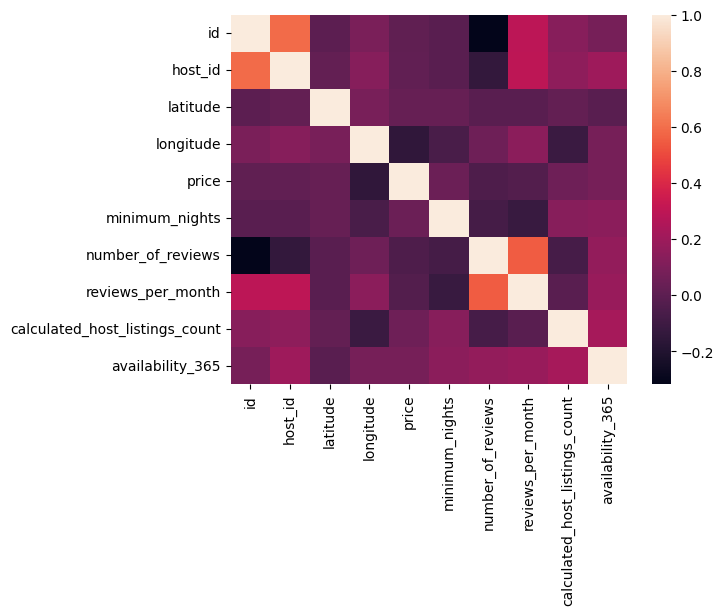

In [7]:
# Reviews per month and number of reviews kinda correlated: better keep just one
sns.heatmap(df_orig.corr())

<AxesSubplot: >

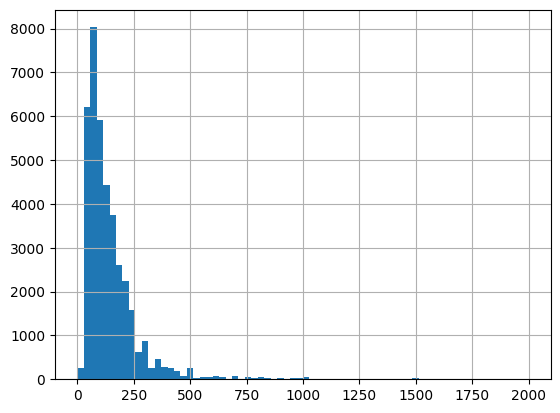

In [30]:
df_orig.price[df_orig.price < 2000].hist(bins=70)

<AxesSubplot: >

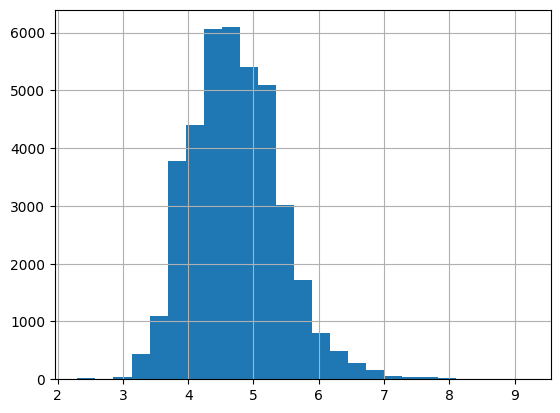

In [33]:
# Log translates it to a normal distribution, so maybe it is more predictable for the model
logg = np.log(df_orig.price[df_orig.price > 0])
logg.hist(bins=25)

# Outlier 


In [10]:
df_outliers = df_orig.drop(["id","name","host_id","host_name", #ID columns, useless for regressiong
                               "neighbourhood", # We only keep neighbourhood_groups
                               "last_review", # Kinda useless
                               "latitude", # Way too specific
                               "longitude", # Way too specific
                                "reviews_per_month" # We only keep number_of_reviews
                              ], axis=1)

Shape before:  (39116, 7)
Shape after:  (38607, 7)
neighbourhood_group               0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0


C:\Users\User\jupytervenv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_20924\3359453701.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price = np.exp(df.price)


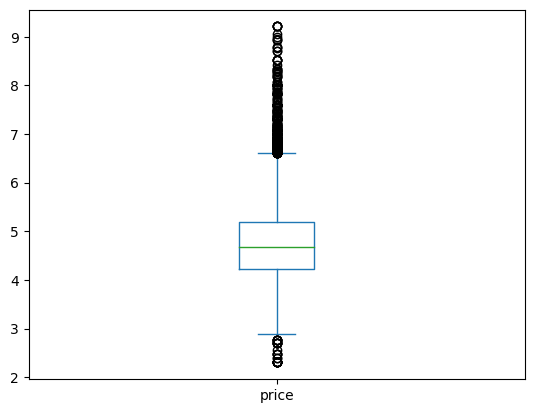

In [11]:
# # Boxplot outiler extraction
df_outliers.price = np.log(df_outliers.price)
q25 = df_outliers.price.quantile(0.25)
q75 = df_outliers.price.quantile(0.75)
IQR = q75-q25
df_outliers.price.plot.box()

print("Shape before: ", df_outliers.shape)
df = df_outliers[(df_outliers.price > q25-1.5*IQR) & (df_outliers.price < q75+1.5*IQR)]
      
print("Shape after: ", df.shape)

print(df.isna().sum().to_string())

df.price = np.exp(df.price)

In [12]:
# Also delete everything that has price =0 (not relevant data)
print (df.shape)
df = df[df.price > 0] # Ten of them had price =0
print(df.shape)
# Ten of them had price =0

(38607, 7)
(38607, 7)


# Preprocessing

In [13]:
from sklearn.preprocessing import OneHotEncoder

roomtype = pd.DataFrame(df["room_type"])
ohe_rt = OneHotEncoder(sparse=False, dtype=int)

transformed = ohe_rt.fit_transform(roomtype)
rt_df = pd.DataFrame(transformed, index=df.index, columns=ohe_rt.get_feature_names_out())
df = pd.concat([df, rt_df], axis=1).drop("room_type", axis=1)

In [14]:
nbg = pd.DataFrame(df["neighbourhood_group"])
ohe_nbg = OneHotEncoder(sparse=False, dtype=int)
transformed = ohe_nbg.fit_transform(nbg)
nbg_df = pd.DataFrame(transformed, index=df.index, columns=ohe_nbg.get_feature_names_out())
df = pd.concat([df, nbg_df], axis=1).drop("neighbourhood_group", axis=1)


In [15]:
# Go to logarithmic
# df.price = np.log(df.price)

In [16]:
df.head()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,75.0,1,2,3,351,0,1,0,0,0,0,1,0
1,95.0,1,202,2,263,0,1,0,0,0,1,0,0
2,130.0,2,0,1,0,1,0,0,0,0,1,0,0
3,150.0,2,4,1,89,1,0,0,0,1,0,0,0
4,325.0,3,16,1,103,1,0,0,0,1,0,0,0


# Model development


In [17]:
y = df.price
X = df.drop("price", axis=1)

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [19]:
def evaluate_model(X, y, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    y_train = np.log(y_train)
    
    # predict the test points
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_hat = np.exp(y_hat)
    
    return mean_squared_error(y_test, y_hat), r2_score(y_test, y_hat)

In [20]:
models = [
    LinearRegression(),
    Ridge(random_state=42),
    MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
    MLPRegressor(hidden_layer_sizes=(10,10),  activation='tanh', solver='lbfgs',
                 alpha=0.000, batch_size='auto', learning_rate='constant',
                 learning_rate_init=0.01, power_t=0.5, max_iter=10000, shuffle=True,
                 random_state=42, tol=0.0001, verbose=True, warm_start=False,
                 momentum=0.0, nesterovs_momentum=False, early_stopping=False,
                 validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    SVR(gamma='scale'),
    RandomForestRegressor(n_estimators=300)
]
names = [
    'linreg',
    'ridge',
    'mlp_standard',
    'mlp_tuned',
    'svr',
    'rf']

In [21]:
from prettytable import PrettyTable

t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']

for model, name in zip(models, names):
    print(".", end="")
    mse, r2 = evaluate_model(X, y, model, name)
    t.add_row([name, mse, r2])
    
print()

print(t)

......
+--------------+--------------------+---------------------+
|    model     |        MSE         |          R2         |
+--------------+--------------------+---------------------+
|    linreg    | 6839.360991136732  | 0.33160522716355467 |
|    ridge     | 6683.706847119099  | 0.33634407451084003 |
| mlp_standard | 379723.80489078374 |  -36.56438909808629 |
|  mlp_tuned   | 6635.9073706292265 | 0.34510039614544197 |
|     svr      | 8883.377312477249  |  0.1314471711051559 |
|      rf      |  6251.17864766877  |  0.3780340854234304 |
+--------------+--------------------+---------------------+


In [23]:
my_model=RandomForestRegressor(n_estimators=300)
y_log = np.log(y)
my_model.fit(X,y_log)

RandomForestRegressor(n_estimators=300)

# Try on the evaluation DF


In [22]:
raise Exception("Stop")
df_eval = pd.read_csv("NYC_Airbnb/evaluation.csv")
df_eval.shape

Exception: Stop

In [ ]:
df = df_eval.drop(["id","name","host_id","host_name", #ID columns, useless for regressiong
                               "neighbourhood", # We only keep neighbourhood_groups
                               "last_review", # Kinda useless
                               "latitude", # Way too specific
                               "longitude", # Way too specific
                                "reviews_per_month" # We only keep number_of_reviews
                              ], axis=1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

roomtype = pd.DataFrame(df["room_type"])
ohe_rt = OneHotEncoder(sparse=False, dtype=int)
transformed = ohe_rt.fit_transform(roomtype)
rt_df = pd.DataFrame(transformed, index=df.index, columns=ohe_rt.get_feature_names_out())
df = pd.concat([df, rt_df], axis=1).drop("room_type", axis=1)

nbg = pd.DataFrame(df["neighbourhood_group"])
ohe_nbg = OneHotEncoder(sparse=False, dtype=int)
transformed = ohe_nbg.fit_transform(nbg)
nbg_df = pd.DataFrame(transformed, index=df.index, columns=ohe_nbg.get_feature_names_out())
df = pd.concat([df, nbg_df], axis=1).drop("neighbourhood_group", axis=1)

df.shape

In [ ]:
pred = my_model.predict(df)
pred_df = pd.DataFrame(pred)
pred_df.columns = ["Predicted"]
pred_df.to_csv("result.csv",header=True, index=True, index_label="Id")